✓ Imports complete
✓ Loaded data: (7390, 15)
✓ Loaded models
  Optimal threshold: 0.628

Test set: 282 samples
Years: 2020 - 2022
✓ Test data prepared

✓ Predictions generated
  Predicted medal winners: 165
  Actual medal winners: 127


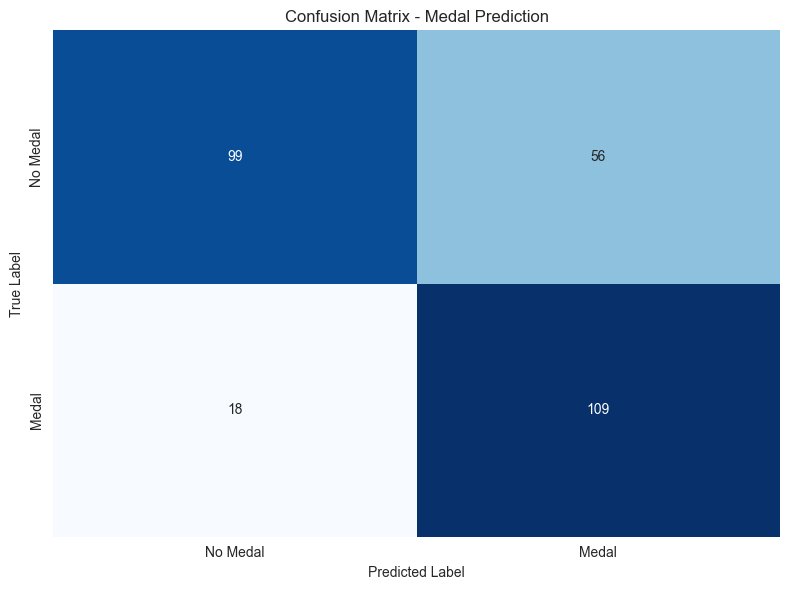


Confusion Matrix:
  True Negatives:  99
  False Positives: 56
  False Negatives: 18
  True Positives:  109

  True Positive Rate:  0.858
  False Positive Rate: 0.361


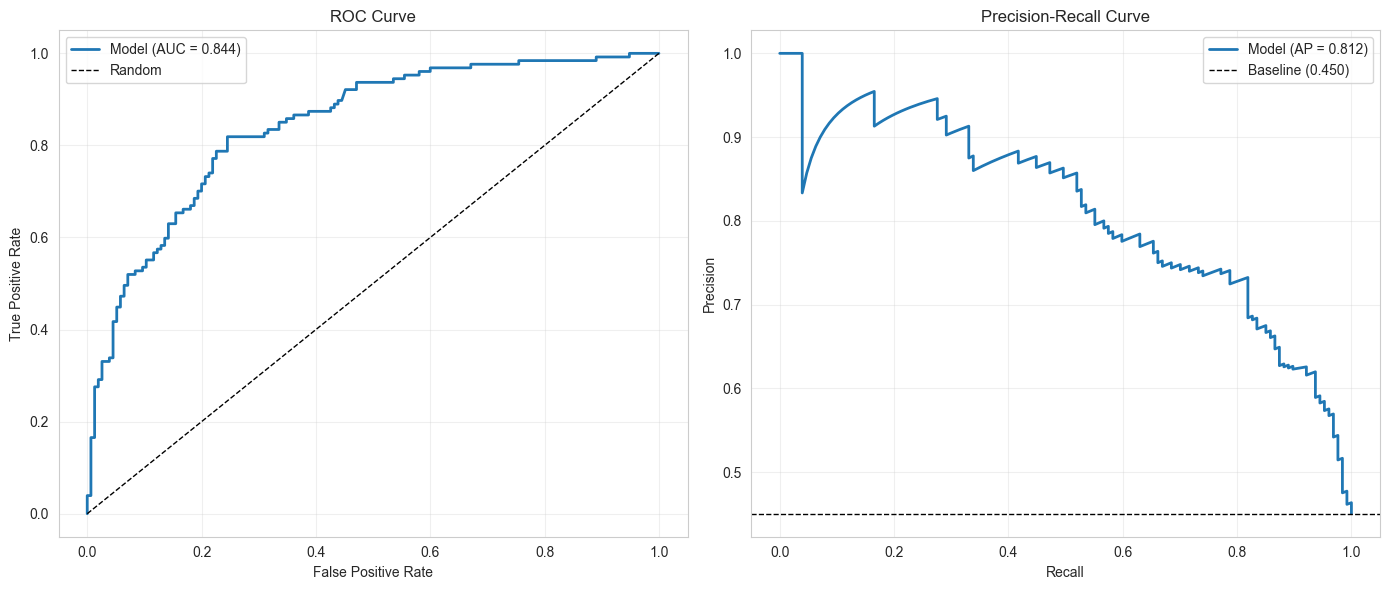


📊 Classification Metrics:
  ROC AUC: 0.8436
  PR AUC:  0.8122


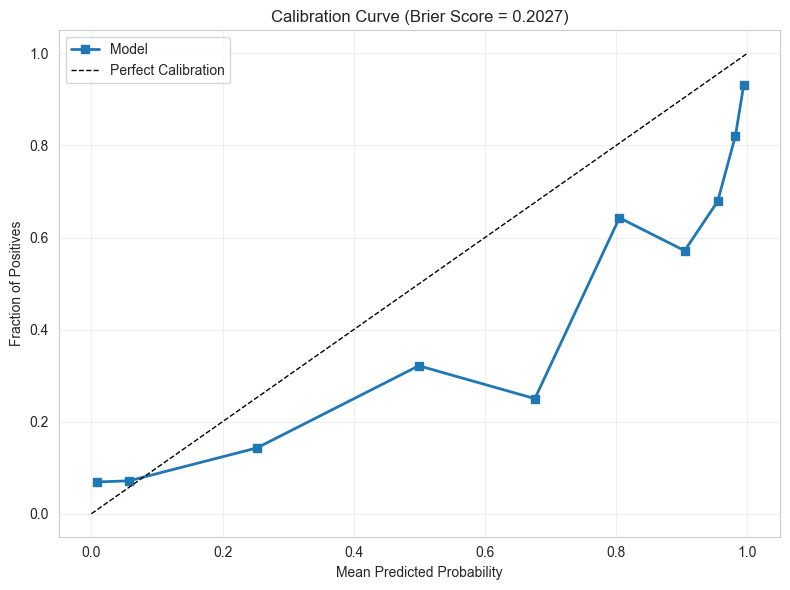


📊 Calibration:
  Brier Score: 0.2027 (lower is better)


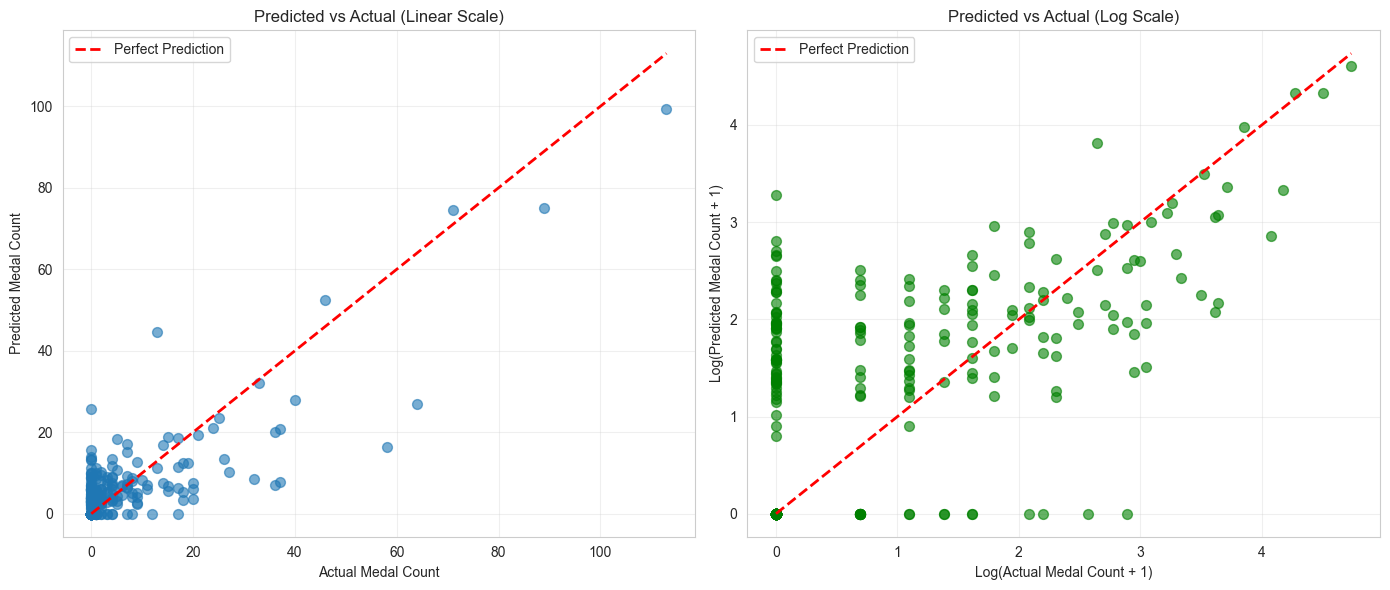


📊 Regression Metrics (All Countries):
  MAE:  3.945
  RMSE: 7.181
  R²:   0.690

📊 Regression Metrics (Actual Winners Only):
  MAE:  6.132
  RMSE: 9.534


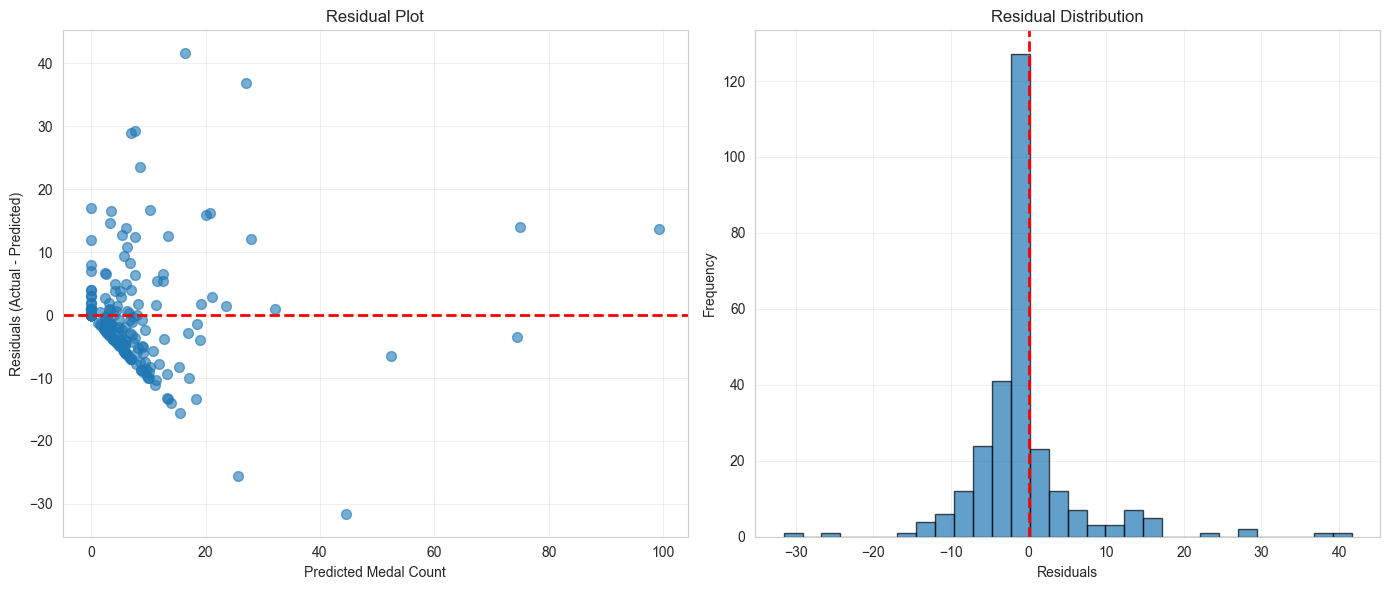


🏅 Top 10 Predicted Medal Winners:
           country  year  actual_medals  predicted_medals
     United States  2020          113.0         99.340721
             China  2020           89.0         74.996361
Russian Federation  2020           71.0         74.504829
         Australia  2020           46.0         52.451225
           Turkiye  2020           13.0         44.574261
            France  2020           33.0         32.099972
             Italy  2020           40.0         27.911762
    United Kingdom  2020           64.0         27.053427
          Pakistan  2020            0.0         25.631153
     United States  2022           25.0         23.482746

🏅 Top 10 Actual Medal Winners:
           country  year  actual_medals  predicted_medals
     United States  2020          113.0         99.340721
             China  2020           89.0         74.996361
Russian Federation  2020           71.0         74.504829
    United Kingdom  2020           64.0         27.053427
     

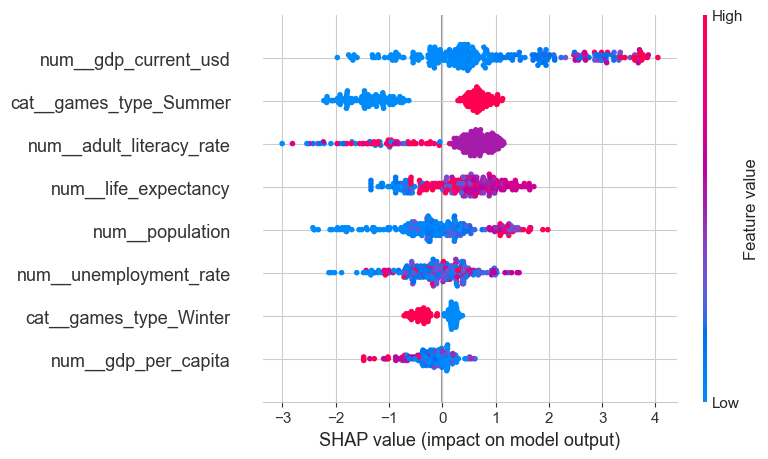

✓ SHAP analysis complete

📄 Generating PDF report...
✓ PDF report saved to results/evaluation_report.pdf

EVALUATION COMPLETE!


In [ ]:
# Olympic Medal Prediction - Complete Evaluation and Reporting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import geopandas as gpd
import warnings
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

warnings.filterwarnings('ignore')

from sklearn.metrics import (
    confusion_matrix, roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score, brier_score_loss,
    mean_absolute_error, mean_squared_error, r2_score,
    classification_report, accuracy_score, precision_score, 
    recall_score, f1_score
)
from sklearn.calibration import calibration_curve
import shap


In [ ]:

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Create directories
Path('results').mkdir(exist_ok=True)
Path('figures').mkdir(exist_ok=True)

print("✓ Imports complete")

# =============================================================================
# 1. LOAD DATA AND MODELS
# =============================================================================

# Load data
df = pd.read_csv('data/processed/olympics_merged.csv')

# Load models
preprocessor = joblib.load('models/preprocessor.joblib')
classifier = joblib.load('models/classifier.joblib')
regressor = joblib.load('models/regressor.joblib')
optimal_threshold = joblib.load('models/optimal_threshold.joblib')

print(f"✓ Loaded data: {df.shape}")
print(f"✓ Loaded models")
print(f"  Optimal threshold: {optimal_threshold:.3f}")

# Recreate test split
# Using the split logic from the training notebook
test_df = df[df['year'] >= 2020].copy()

if len(test_df) < 50:
    test_df = df[df['year'] >= df['year'].quantile(0.85)].copy()

print(f"\nTest set: {len(test_df)} samples")
print(f"Years: {test_df['year'].min()} - {test_df['year'].max()}")

# Prepare features
exclude_cols = ['iso3', 'country_name', 'year', 'gold', 'silver', 'bronze', 
                'total_medals', 'country']
feature_cols = [c for c in df.columns if c not in exclude_cols]

X_test = test_df[feature_cols]
y_test_true = test_df['total_medals'].values
y_test_class_true = (test_df['total_medals'] > 0).astype(int).values

# Transform features
X_test_processed = preprocessor.transform(X_test)

print("✓ Test data prepared")


In [ ]:

# =============================================================================
# 2. GENERATE PREDICTIONS
# =============================================================================

# Stage 1: Classification
y_test_proba = classifier.predict_proba(X_test_processed)[:, 1]
y_test_class_pred = (y_test_proba >= optimal_threshold).astype(int)

# Stage 2: Regression
y_test_medals_pred = np.zeros(len(test_df))
medal_winner_mask = y_test_class_pred == 1

if medal_winner_mask.sum() > 0:
    # Use only the processed features for the predicted winners
    X_test_reg_processed = X_test_processed[medal_winner_mask]
    y_test_medals_pred[medal_winner_mask] = regressor.predict(
        X_test_reg_processed
    )
    y_test_medals_pred = np.maximum(y_test_medals_pred, 0)

print(f"\n✓ Predictions generated")
print(f"  Predicted medal winners: {medal_winner_mask.sum()}")
print(f"  Actual medal winners: {y_test_class_true.sum()}")


# =============================================================================
# 3. CONFUSION MATRIX
# =============================================================================

cm = confusion_matrix(y_test_class_true, y_test_class_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Medal', 'Medal'],
            yticklabels=['No Medal', 'Medal'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Medal Prediction')
plt.tight_layout()
plt.savefig('figures/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]}")
print(f"  False Positives: {cm[0,1]}")
print(f"  False Negatives: {cm[1,0]}")
print(f"  True Positives:  {cm[1,1]}")

# Calculate rates
tpr = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
fpr = cm[0,1] / (cm[0,1] + cm[0,0]) if (cm[0,1] + cm[0,0]) > 0 else 0
print(f"\n  True Positive Rate:  {tpr:.3f}")
print(f"  False Positive Rate: {fpr:.3f}")



In [ ]:

# =============================================================================
# 4. ROC AND PRECISION-RECALL CURVES
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr_curve, tpr_curve, _ = roc_curve(y_test_class_true, y_test_proba)
roc_auc = roc_auc_score(y_test_class_true, y_test_proba)

axes[0].plot(fpr_curve, tpr_curve, linewidth=2, label=f'Model (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_class_true, y_test_proba)
pr_auc = average_precision_score(y_test_class_true, y_test_proba)
baseline_precision = y_test_class_true.sum() / len(y_test_class_true)

axes[1].plot(recall, precision, linewidth=2, label=f'Model (AP = {pr_auc:.3f})')
axes[1].axhline(baseline_precision, color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({baseline_precision:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Classification Metrics:")
print(f"  ROC AUC: {roc_auc:.4f}")
print(f"  PR AUC:  {pr_auc:.4f}")



In [ ]:

# =============================================================================
# 5. CALIBRATION CURVE AND BRIER SCORE
# =============================================================================

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test_class_true, y_test_proba, n_bins=10, strategy='quantile'
)

brier = brier_score_loss(y_test_class_true, y_test_proba)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mean_predicted_value, fraction_of_positives, 's-', linewidth=2, label='Model')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect Calibration')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Fraction of Positives')
ax.set_title(f'Calibration Curve (Brier Score = {brier:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/calibration_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Calibration:")
print(f"  Brier Score: {brier:.4f} (lower is better)")


In [ ]:


# =============================================================================
# 6. PREDICTED VS ACTUAL MEDAL COUNTS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear scale
axes[0].scatter(y_test_true, y_test_medals_pred, alpha=0.6, s=50)
max_val = max(y_test_true.max(), y_test_medals_pred.max()) if len(y_test_true) > 0 else 1
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Medal Count')
axes[0].set_ylabel('Predicted Medal Count')
axes[0].set_title('Predicted vs Actual (Linear Scale)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log scale
y_test_true_log = np.log1p(y_test_true)
y_test_medals_pred_log = np.log1p(y_test_medals_pred)
max_val_log = max(y_test_true_log.max(), y_test_medals_pred_log.max()) if len(y_test_true_log) > 0 else 1
axes[1].scatter(y_test_true_log, y_test_medals_pred_log, alpha=0.6, s=50, color='green')
axes[1].plot([0, max_val_log], [0, max_val_log], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Log(Actual Medal Count + 1)')
axes[1].set_ylabel('Log(Predicted Medal Count + 1)')
axes[1].set_title('Predicted vs Actual (Log Scale)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/predicted_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate regression errors (all countries)
mae = mean_absolute_error(y_test_true, y_test_medals_pred)
rmse = np.sqrt(mean_squared_error(y_test_true, y_test_medals_pred))
r2 = r2_score(y_test_true, y_test_medals_pred)

# Calculate errors only for actual medal winners
actual_winners_mask = y_test_true > 0
if actual_winners_mask.sum() > 0:
    mae_winners = mean_absolute_error(
        y_test_true[actual_winners_mask], 
        y_test_medals_pred[actual_winners_mask]
    )
    rmse_winners = np.sqrt(mean_squared_error(
        y_test_true[actual_winners_mask], 
        y_test_medals_pred[actual_winners_mask]
    ))
else:
    mae_winners = rmse_winners = np.nan

print(f"\n📊 Regression Metrics (All Countries):")
print(f"  MAE:  {mae:.3f}")
print(f"  RMSE: {rmse:.3f}")
print(f"  R²:   {r2:.3f}")
print(f"\n📊 Regression Metrics (Actual Winners Only):")
print(f"  MAE:  {mae_winners:.3f}")
print(f"  RMSE: {rmse_winners:.3f}")


In [ ]:


# =============================================================================
# 7. RESIDUAL ANALYSIS
# =============================================================================

residuals = y_test_true - y_test_medals_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Residuals vs Predicted
axes[0].scatter(y_test_medals_pred, residuals, alpha=0.6, s=50)
axes[0].axhline(0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Medal Count')
axes[0].set_ylabel('Residuals (Actual - Predicted)')
axes[0].set_title('Residual Plot')
axes[0].grid(True, alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:


# =============================================================================
# 8. TOP PREDICTIONS VS ACTUAL (Results Table)
# =============================================================================

# Create results dataframe
results_df = test_df[['country', 'year', 'games_type', 'iso3']].copy()
results_df['actual_medals'] = y_test_true
results_df['predicted_medals'] = y_test_medals_pred
results_df['predicted_proba'] = y_test_proba
results_df['error'] = results_df['actual_medals'] - results_df['predicted_medals']
results_df['abs_error'] = np.abs(results_df['error'])

# Top 10 predicted
top_predicted = results_df.nlargest(10, 'predicted_medals')
print("\n🏅 Top 10 Predicted Medal Winners:")
print(top_predicted[['country', 'year', 'actual_medals', 'predicted_medals']].to_string(index=False))

# Top 10 actual
top_actual = results_df.nlargest(10, 'actual_medals')
print("\n🏅 Top 10 Actual Medal Winners:")
print(top_actual[['country', 'year', 'actual_medals', 'predicted_medals']].to_string(index=False))

# Biggest errors
biggest_errors = results_df.nlargest(10, 'abs_error')
print("\n❌ Top 10 Prediction Errors:")
print(biggest_errors[['country', 'year', 'actual_medals', 'predicted_medals', 'error']].to_string(index=False))

# Save results
results_df.to_csv('results/evaluation_results.csv', index=False)
print("\n✓ Results saved to results/evaluation_results.csv")


# =============================================================================
# 9. GEOGRAPHICAL VISUALIZATION (Choropleth Map)
# =============================================================================

try:
    # Get world map data (requires a local shapefile or GeoPandas installed with a dataset)
    # Using a common built-in dataset for demonstration, replace with your specific map file if needed
    # Note: Requires geopandas and either an installed world dataset or local shapefile
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Clean up and prepare for merge
    map_data = results_df.groupby('iso3').agg({
        'predicted_medals': 'sum',
        'actual_medals': 'sum'
    }).reset_index()
    
    # Merge with world map using ISO3 codes
    world_merged = world.merge(map_data, left_on='iso_a3', right_on='iso3', how='left')
    world_merged['predicted_medals'] = world_merged['predicted_medals'].fillna(0)
    world_merged['actual_medals'] = world_merged['actual_medals'].fillna(0)
    
    # Plotting Predicted Medals
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world_merged.plot(column='predicted_medals', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                      missing_kwds={'color': 'lightgray'})
    ax.set_title(f'Predicted Total Medals ({test_df["year"].min()}-{test_df["year"].max()})')
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig('figures/choropleth_predicted.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Choropleth map generated.")
    
except Exception as e:
    print(f"\n⚠️ Could not generate choropleth map. Error: {e}. (Ensure 'geopandas' is installed and map data is available.)")


# =============================================================================
# 10. SHAP ANALYSIS (for Classification Stage)
# =============================================================================

# This part is important for model explainability
print("\n🔍 Computing SHAP values (this may take a while)...")

try:
    # Sample data for SHAP (use subset for speed)
    sample_size = min(500, len(X_test_processed))
    sample_indices = np.random.choice(len(X_test_processed), sample_size, replace=False)
    X_sample = X_test_processed[sample_indices]

    # SHAP for classifier
    explainer_clf = shap.TreeExplainer(classifier)
    shap_values_clf = explainer_clf.shap_values(X_sample)

    # If binary classification, take positive class
    if isinstance(shap_values_clf, list):
        shap_values_clf = shap_values_clf[1]

    # Get feature names from preprocessor
    feature_names = preprocessor.get_feature_names_out()

    fig, ax = plt.subplots(figsize=(12, 8))
    shap.summary_plot(shap_values_clf, X_sample, 
                    feature_names=feature_names, 
                    show=False, max_display=15)
    plt.tight_layout()
    plt.savefig('figures/shap_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ SHAP analysis complete")

except Exception as e:
    print(f"❌ Error during SHAP analysis: {e}")


# =============================================================================
# 11. GENERATE PDF REPORT
# =============================================================================

# Recalculate full classification metrics for the report summary
accuracy = accuracy_score(y_test_class_true, y_test_class_pred)
precision = precision_score(y_test_class_true, y_test_class_pred)
recall = recall_score(y_test_class_true, y_test_class_pred)
f1 = f1_score(y_test_class_true, y_test_class_pred)

print("\n📄 Generating PDF report...")

with PdfPages('results/evaluation_report.pdf') as pdf:
    # Page 1: Title and Summary
    fig = plt.figure(figsize=(11, 8.5))
    fig.text(0.5, 0.9, 'Olympic Medal Prediction', 
             ha='center', fontsize=24, fontweight='bold')
    fig.text(0.5, 0.85, 'Evaluation Report', 
             ha='center', fontsize=18)
    
    summary_text = f"""
    Evaluation Summary
    ==================
    
    Test Set: {len(test_df)} samples ({test_df['year'].min()}-{test_df['year'].max()})
    
    Classification Performance:
    • Accuracy: {accuracy:.4f}
    • Precision: {precision:.4f}
    • Recall: {recall:.4f}
    • F1 Score: {f1:.4f}
    • ROC AUC: {roc_auc:.4f}
    • PR AUC: {pr_auc:.4f}
    • Brier Score: {brier:.4f}
    
    Regression Performance (All):
    • MAE: {mae:.3f} medals
    • RMSE: {rmse:.3f} medals
    • R²: {r2:.3f}
    
    Regression Performance (Actual Winners Only):
    • MAE: {mae_winners:.3f} medals
    • RMSE: {rmse_winners:.3f} medals
    
    Predictions:
    • Predicted Medal Winners: {medal_winner_mask.sum()}
    • Actual Medal Winners: {y_test_class_true.sum()}
    • True Positives: {cm[1,1]}
    • False Positives: {cm[0,1]}
    • False Negatives: {cm[1,0]}
    """
    
    fig.text(0.1, 0.7, summary_text, fontsize=11, verticalalignment='top', 
             family='monospace')
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()
    
    # Add existing figures
    for fig_path in ['confusion_matrix', 'roc_pr_curves', 'calibration_curve', 
                     'predicted_vs_actual', 'residual_analysis', 'shap_summary',
                     'choropleth_predicted']:
        fig_file = f'figures/{fig_path}.png'
        if Path(fig_file).exists():
            img = plt.imread(fig_file)
            fig, ax = plt.subplots(figsize=(11, 8.5))
            ax.imshow(img)
            ax.axis('off')
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()

print("✓ PDF report saved to results/evaluation_report.pdf")

print("\n" + "="*60)
print("EVALUATION COMPLETE!")
print("="*60)

# Two-Stage Olympic Medal Prediction Model

## Overview
This notebook implements a two-stage prediction approach:
1. **Stage A (Classification)**: Predict whether a country wins any medals (binary)
2. **Stage B (Regression)**: Predict medal count for countries predicted to win medals

## What to Run
Simply run all cells in order. The notebook will:
- Load and explore data
- Preprocess features with pipelines
- Split data by time (train ≤2012, val=2016, test=2020+)
- Train classifier and regressor with hyperparameter tuning
- Evaluate both stages
- Save models for inference